# Examine the correlation between consistency and importance pattern similarity

In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
import scipy
import random

from experiments.causal_trace import plot_trace_heatmap, plot_trace_heatmap_from_values, plot_normalized_trace_heatmap_from_values

In [2]:
query_file = "/cephyr/users/lovhag/Alvis/projects/rome/data/P19_gpt2_xl_preds.jsonl"
results_folder = "/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P19/causal_trace_pararel_1711765"

In [3]:
queries = pd.DataFrame()
with open(query_file) as f:
    for line in f:
        queries = queries.append(json.loads(line), ignore_index=True)
        
queries.head()

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,top10_tokens,top10_tokens_probs
0,Alexandra,0.024580,London,2.0,0.000011,3197.0,0.0,New,0.038592,Allan Peiper was born in,P19,Allan Peiper,{} was born in,"[ New, the, London, 18, Toronto, Montreal...","[0.03859247639775276, 0.03803418204188347, 0.0..."
1,Alexandra,0.029013,Canada,2.0,0.000011,3354.0,1.0,the,0.077758,Allan Peiper is originally from,P19,Allan Peiper,{} is originally from,"[ New, the, London, 18, Toronto, Montreal...","[0.04142675921320915, 0.07775774598121643, 0.0..."
2,Alexandra,0.023173,Canada,2.0,0.000013,3389.0,2.0,the,0.079163,Allan Peiper was originally from,P19,Allan Peiper,{} was originally from,"[ New, the, London, 18, Toronto, Montreal...","[0.03634488210082054, 0.07916285842657089, 0.0..."
3,Alexandra,0.035623,Canada,2.0,0.000005,4780.0,3.0,the,0.154659,Allan Peiper is native to,P19,Allan Peiper,{} is native to,"[ New, the, London, 18, Toronto, Montreal...","[0.03823259472846985, 0.15465885400772095, 0.0..."
4,Alexandra,0.032304,Canada,1.0,0.000007,4640.0,4.0,the,0.132673,Allan Peiper was native to,P19,Allan Peiper,{} was native to,"[ New, the, London, 18, Toronto, Montreal...","[0.029023099690675735, 0.13267268240451813, 0...."


## Get KL divergences and corresponding consistency values for pairwise comparisons between the LAMA template and other templates

The functions below are copied from `analyze_pararel_causal_tracing_results_top10`.

In [4]:
def get_tokens_ix_to_trace_for(input_tokens, subject_tokens_ix):
    # keep subject tokens and last token distinct for the analysis
    last_token_ix = len(input_tokens)-1
    assert last_token_ix not in subject_tokens_ix, "This analysis assumes that the last token is not a subject token"
    
    distinct_tokens_ix = set(subject_tokens_ix+[last_token_ix])
    other_tokens_ix = list(set(range(len(input_tokens)))-distinct_tokens_ix)
    return list(distinct_tokens_ix), other_tokens_ix

def get_token_layer_scores(results, token_ix):
    scores = results["scores"][:,:,token_ix]
    subject_tokens_ix = list(range(*results["subject_range"]))
    distinct_tokens_ix, other_tokens_ix = get_tokens_ix_to_trace_for(results["input_tokens"], subject_tokens_ix)

    token_layer_scores = np.concatenate([scores[distinct_tokens_ix], [scores[other_tokens_ix].mean(axis=0)]])
    #token_layer_scores = np.concatenate([scores[ix,:] for ix in subject_tokens_ix]+[scores[0,:], scores[-1,:], scores[other_tokens_ix,:].mean(axis=0)])
    token_layer_scores = token_layer_scores.flatten()/token_layer_scores.flatten().sum()
    
    return token_layer_scores

def plot_te_heatmap(results, token_ix, answer):
    te = (results["scores"][:,:,token_ix]-results["low_score"][token_ix])/abs(results["high_score"][token_ix]-results["low_score"][token_ix])
    window = results.get("window", 10)
    kind = str(results["kind"])
    labels = list(results["input_tokens"])
    for i in range(*results["subject_range"]):
        labels[i] = labels[i] + "*"
    bartitle = f"(p**-p*)/(p-p*)"
    plot_normalized_trace_heatmap_from_values(te, -0.5, 1.5, bartitle, kind, window, labels,
                                   savepdf=False, title=f"Impact of restoring MLP for output '{answer.strip()}'", xlabel=None, modelname=None)

In [5]:
data = []
cand_data = []

for subject in queries.subject.unique()[:200]: #random.sample(list(queries.subject.unique()[:200]), 3): #queries.subject.unique()[:200]:
    sample_ixs = list(queries[queries.subject==subject].index)
    token_ix = 0 #always measure for top predicted token (or candidate, TODO)
    answer = queries.loc[sample_ixs[0]]["top10_tokens"][token_ix]
    results_lama = np.load(os.path.join(results_folder, f"cases/{sample_ixs[0]}_any_mlp.npz"), allow_pickle=True)
    
    cand_answer = queries.loc[sample_ixs[0]]["candidate_prediction"]
    cand_token_ix = None
    try:
        cand_token_ix = queries.loc[sample_ixs[0]]["top10_tokens"].index(cand_answer)
    except: 
        print("Warning: Candidate prediciton not in top 10 tokens for the sample below.")
        print(queries.loc[sample_ixs[0]])
        
    for sample_ix in sample_ixs[1:]:
        results = np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True)
        dict_data = {"sample_ix": sample_ix, 
                     "lama_ix": sample_ixs[0],
                     "subject": subject,
                     "lama_template": queries.loc[sample_ixs[0]]["template"],
                     "sample_template": queries.loc[sample_ix]["template"],
                     "lama_answer": answer.strip(),
                     "sample_answer": queries.loc[sample_ix]["prediction"],
                     "lama_te": results_lama["high_score"][token_ix]-results_lama["low_score"][token_ix],
                     "sample_te": results["high_score"][token_ix]-results["low_score"][token_ix],
                     "is_consistent": queries.loc[sample_ix]["prediction"]==answer}
        
        token_layer_scores = get_token_layer_scores(results, token_ix)
        token_layer_scores_to_compare = get_token_layer_scores(results_lama, token_ix)
        dict_data["kl_div"] = sum(scipy.special.rel_entr(token_layer_scores, token_layer_scores_to_compare))
        
        data.append(dict_data)
        
        if cand_token_ix is not None:
            cand_dict_data = dict_data.copy()
            cand_dict_data["lama_answer"] = cand_answer
            cand_dict_data["sample_answer"] = queries.loc[sample_ix]["candidate_prediction"]
            cand_dict_data["lama_te"] = results_lama["high_score"][cand_token_ix]-results_lama["low_score"][cand_token_ix]
            cand_dict_data["sample_te"] = results["high_score"][cand_token_ix]-results["low_score"][cand_token_ix]
            cand_dict_data["is_consistent"] = cand_dict_data["sample_answer"]==cand_answer
            
            token_layer_scores = get_token_layer_scores(results, cand_token_ix)
            token_layer_scores_to_compare = get_token_layer_scores(results_lama, cand_token_ix)
            cand_dict_data["kl_div"] = sum(scipy.special.rel_entr(token_layer_scores, token_layer_scores_to_compare))
            
            cand_data.append(cand_dict_data)
        
cand_data = pd.DataFrame(cand_data)
data = pd.DataFrame(data)
data.head()

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,lama_te,sample_te,is_consistent,kl_div
0,1,0,Allan Peiper,{} was born in,{} is originally from,New,the,0.023766,0.021967,False,0.005852
1,2,0,Allan Peiper,{} was born in,{} was originally from,New,the,0.023766,0.018423,False,0.006108
2,3,0,Allan Peiper,{} was born in,{} is native to,New,the,0.023766,0.022872,False,0.014825
3,4,0,Allan Peiper,{} was born in,{} was native to,New,the,0.023766,0.016975,False,0.012629
4,5,0,Allan Peiper,{} was born in,{} originated from,New,the,0.023766,0.015993,False,0.074903


### Analysis of non-filtered consistency

In [87]:
len(queries.subject.unique())

779

In [67]:
len(data)

1200

In [31]:
len(data[(data.lama_te>0)&(data.sample_te>0)])

541

In [12]:
data.is_consistent.sum()

611

In [91]:
data.drop(columns=["sample_ix", "lama_ix"]).corr()

,lama_te,sample_te,is_consistent,kl_div
lama_te,1.000000,0.765009,-0.783489,0.517018
sample_te,0.765009,1.000000,-0.660228,0.379365
is_consistent,-0.783489,-0.660228,1.000000,-0.473753
kl_div,0.517018,0.379365,-0.473753,1.000000


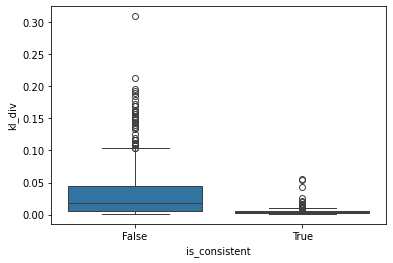

In [55]:
sns.boxplot(data=data, x="is_consistent", y="kl_div")
plt.show()

Only for cases for which te>0.

In [56]:
print(f"TE is positive for {sum((data.lama_te>0) & (data.sample_te>0))} samples out of {len(data)}.")

TE is positive for 541 samples out of 1200.


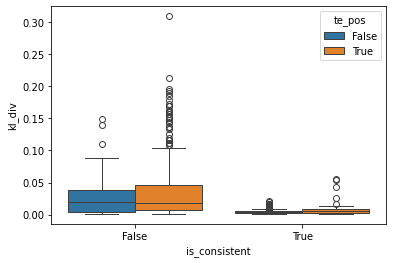

In [57]:
plot_data = data.copy()
plot_data["te_pos"] = (plot_data.lama_te>0) & (plot_data.sample_te>0)
sns.boxplot(data=plot_data, x="is_consistent", y="kl_div", hue="te_pos")
plt.show()

The top predictions for which TE is positive.

In [58]:
data[(data.lama_te>0) & (data.sample_te>0)].lama_answer.value_counts()

New        176
London      90
18          53
Paris       42
Rome        42
Tokyo       18
Germany     18
17          17
Mumbai      12
Moscow      12
15          10
the          9
Vienna       6
Seoul        6
Hong         6
Finland      6
Mexico       6
Iran         6
Dublin       6
Name: lama_answer, dtype: int64

### Inlier analysis
Examine some samples that agree with our expectations.

In [12]:
check_data = data[(data.is_consistent) & (data.kl_div<0.05) & (data.sample_te>0)] # data[~(data.is_consistent) & (data.kl_div>0.05)]
check_data

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,lama_te,sample_te,is_consistent,kl_div
151,177,175,Sirindhorn,{} was born in,{} was originally from,the,the,-0.022790,0.001276,True,0.001070
152,178,175,Sirindhorn,{} was born in,{} is native to,the,the,-0.022790,0.112425,True,0.002542
153,179,175,Sirindhorn,{} was born in,{} was native to,the,the,-0.022790,0.021579,True,0.001654
154,180,175,Sirindhorn,{} was born in,{} originated from,the,the,-0.022790,0.079272,True,0.004348
155,181,175,Sirindhorn,{} was born in,{} originates from,the,the,-0.022790,0.043692,True,0.002216
240,281,280,Parviz Davoodi,{} was born in,{} is originally from,Iran,Iran,0.137497,0.311235,True,0.008047
241,282,280,Parviz Davoodi,{} was born in,{} was originally from,Iran,Iran,0.137497,0.232244,True,0.006373
242,283,280,Parviz Davoodi,{} was born in,{} is native to,Iran,Iran,0.137497,0.211879,True,0.025624
243,284,280,Parviz Davoodi,{} was born in,{} was native to,Iran,Iran,0.137497,0.193289,True,0.017034
268,313,308,Joey Boy,{} was born in,{} originated from,the,the,-0.067072,0.009838,True,0.009198


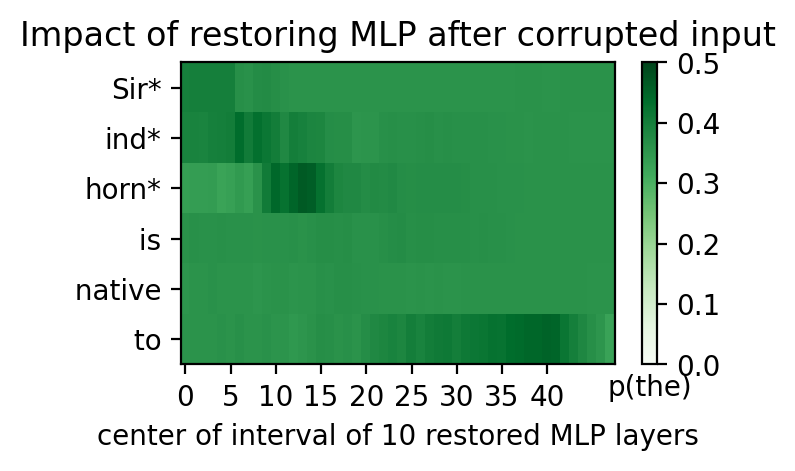

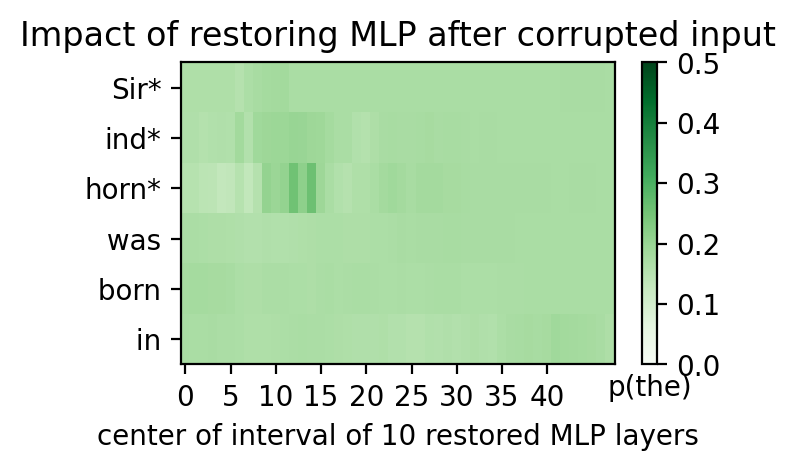

In [14]:
check_data_ix = 1
sample_ix = check_data.iloc[check_data_ix]["sample_ix"]
token_ix = 0
results = dict(np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True))
results["scores"] = results["scores"][:,:,token_ix]
results["low_score"] = 0#results["low_score"][token_ix]
results["high_score"] = 0.5#results["high_score"][token_ix]
results["answer"] = queries.loc[sample_ix]["top10_tokens"][token_ix]
plot_trace_heatmap(results)

sample_ix = check_data.iloc[check_data_ix]["lama_ix"]
results = dict(np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True))
results["scores"] = results["scores"][:,:,token_ix]
results["low_score"] = 0#results["low_score"][token_ix]
results["high_score"] = 0.5#results["high_score"][token_ix]
results["answer"] = queries.loc[sample_ix]["top10_tokens"][token_ix]
plot_trace_heatmap(results)

### Outlier analysis
In some cases the KL divergence is (1) high even though the model is consistent, and vice versa, (2) in some cases the KL divergence is low when the model is inconsistent.

#### Analysis of case 1: KL div high when consistent

In [10]:
weird_data = data[(data.is_consistent) & (data.kl_div>0.02)]
weird_data

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,lama_te,sample_te,is_consistent,kl_div
242,283,280,Parviz Davoodi,{} was born in,{} is native to,Iran,Iran,0.137497,0.211879,True,0.025624
310,362,357,Tony Rumble,{} was born in,{} originated from,the,the,-0.080745,0.042819,True,0.021172
368,430,427,Tobias Rau,{} was born in,{} is native to,Germany,Germany,0.080924,0.204830,True,0.043179
402,470,469,Jack Wong Sue,{} was born in,{} is originally from,Hong,Hong,0.123169,0.140242,True,0.053716
1190,1389,1386,Bernhard Sekles,{} was born in,{} is native to,Germany,Germany,0.049766,0.153831,True,0.054717


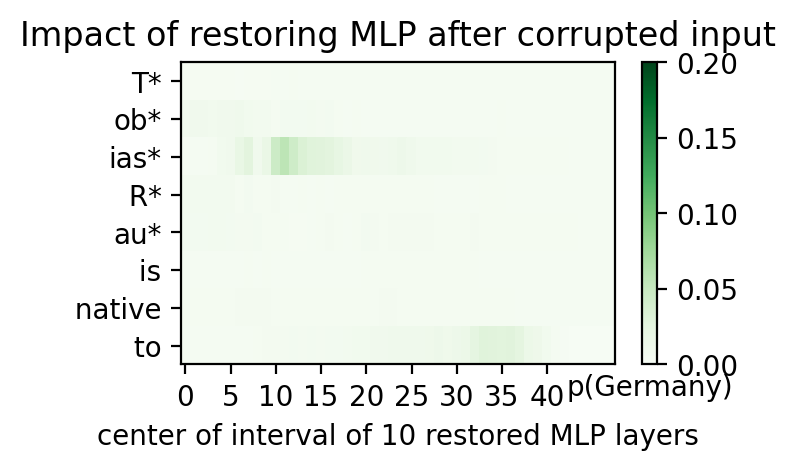

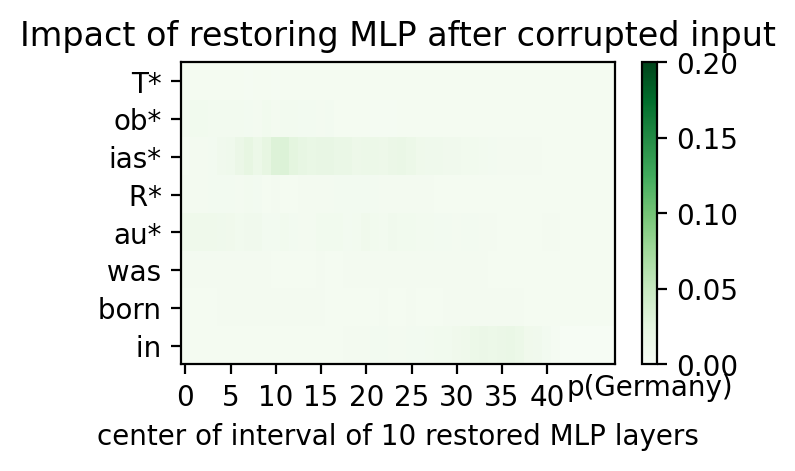

In [11]:
weird_data_ix = 2
sample_ix = weird_data.iloc[weird_data_ix]["sample_ix"]
token_ix = 0
results = dict(np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True))
results["scores"] = results["scores"][:,:,token_ix]
results["low_score"] = 0#results["low_score"][token_ix]
results["high_score"] = 0.2#results["high_score"][token_ix]
results["answer"] = queries.loc[sample_ix]["top10_tokens"][token_ix]
plot_trace_heatmap(results)

sample_ix = weird_data.iloc[weird_data_ix]["lama_ix"]
results = dict(np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True))
results["scores"] = results["scores"][:,:,token_ix]
results["low_score"] = 0#results["low_score"][token_ix]
results["high_score"] = 0.2#results["high_score"][token_ix]
results["answer"] = queries.loc[sample_ix]["top10_tokens"][token_ix]
plot_trace_heatmap(results)

#### Analysis of case 2: KL div low when inconsistent

In [15]:
weird_data = data[~(data.is_consistent) & (data.kl_div<0.05)]
weird_data

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,lama_te,sample_te,is_consistent,kl_div
0,1,0,Allan Peiper,{} was born in,{} is originally from,New,the,0.023766,0.021967,False,0.006033
1,2,0,Allan Peiper,{} was born in,{} was originally from,New,the,0.023766,0.018423,False,0.006399
2,3,0,Allan Peiper,{} was born in,{} is native to,New,the,0.023766,0.022872,False,0.017647
3,4,0,Allan Peiper,{} was born in,{} was native to,New,the,0.023766,0.016975,False,0.014291
5,6,0,Allan Peiper,{} was born in,{} originates from,New,the,0.023766,0.015028,False,0.029156
...,...,...,...,...,...,...,...,...,...,...,...
1168,1363,1358,Francesco Foscari,{} was born in,{} originated from,Rome,the,0.079516,0.024632,False,0.046811
1169,1364,1358,Francesco Foscari,{} was born in,{} originates from,Rome,the,0.079516,0.027504,False,0.035384
1191,1390,1386,Bernhard Sekles,{} was born in,{} was native to,Germany,the,0.049766,0.083945,False,0.026842
1192,1391,1386,Bernhard Sekles,{} was born in,{} originated from,Germany,the,0.049766,0.065885,False,0.040795


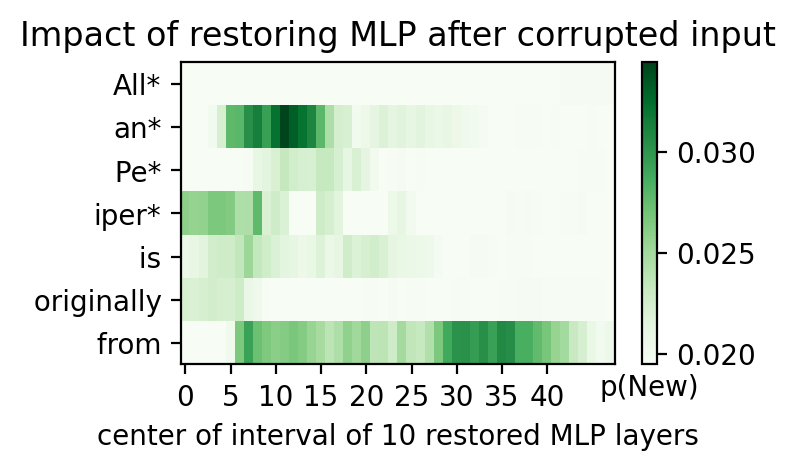

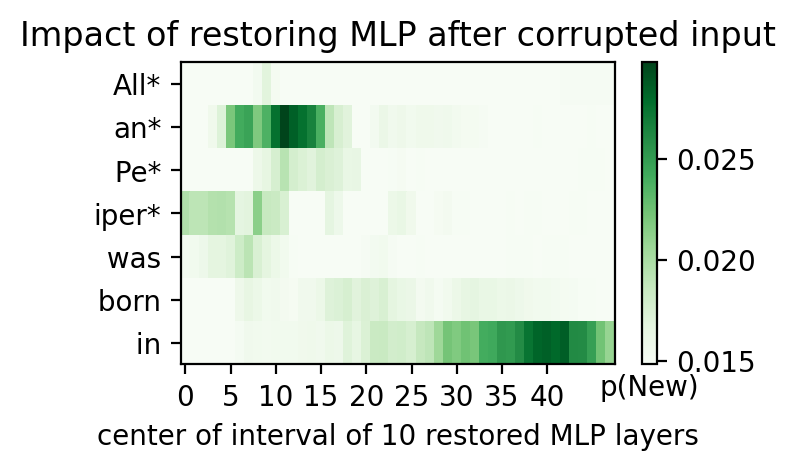

In [16]:
weird_data_ix = 0
sample_ix = weird_data.iloc[weird_data_ix]["sample_ix"]
token_ix = 0
results = dict(np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True))
results["scores"] = results["scores"][:,:,token_ix]
results["low_score"] = results["low_score"][token_ix]
results["high_score"] = results["high_score"][token_ix]
results["answer"] = queries.loc[sample_ix]["top10_tokens"][token_ix]
plot_trace_heatmap(results)

sample_ix = weird_data.iloc[weird_data_ix]["lama_ix"]
results = dict(np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True))
results["scores"] = results["scores"][:,:,token_ix]
results["low_score"] = results["low_score"][token_ix]
results["high_score"] = results["high_score"][token_ix]
results["answer"] = queries.loc[sample_ix]["top10_tokens"][token_ix]
plot_trace_heatmap(results)

### Analysis of candidate-filtered consistency

In [72]:
cand_data.head()

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,lama_te,sample_te,is_consistent,kl_div
0,1,0,Allan Peiper,{} was born in,{} is originally from,London,Canada,0.017587,0.003975,False,0.009200
1,2,0,Allan Peiper,{} was born in,{} was originally from,London,Canada,0.017587,0.003594,False,0.009349
2,3,0,Allan Peiper,{} was born in,{} is native to,London,Canada,0.017587,0.002433,False,0.048972
3,4,0,Allan Peiper,{} was born in,{} was native to,London,Canada,0.017587,0.002815,False,0.039520
4,5,0,Allan Peiper,{} was born in,{} originated from,London,Canada,0.017587,0.004101,False,0.083419


In [73]:
len(cand_data)

1200

In [75]:
cand_data.is_consistent.sum()

461

In [92]:
cand_data.drop(columns=["sample_ix", "lama_ix"]).corr()

,lama_te,sample_te,is_consistent,kl_div
lama_te,1.000000,0.578960,0.123357,0.134865
sample_te,0.578960,1.000000,0.323531,0.086840
is_consistent,0.123357,0.323531,1.000000,0.002490
kl_div,0.134865,0.086840,0.002490,1.000000


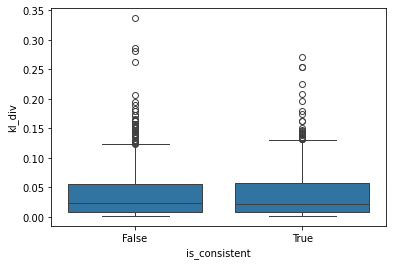

In [30]:
sns.boxplot(data=cand_data, x="is_consistent", y="kl_div")
plt.show()

Only for cases for which te>0.

In [34]:
print(f"TE is positive for {sum((cand_data.lama_te>0) & (cand_data.sample_te>0))} samples out of {len(cand_data)}.")

TE is positive for 1114 samples out of 1200.


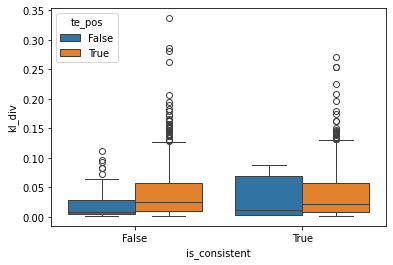

In [31]:
plot_data = cand_data.copy()
plot_data["te_pos"] = (plot_data.lama_te>0) & (plot_data.sample_te>0)
sns.boxplot(data=plot_data, x="is_consistent", y="kl_div", hue="te_pos")
plt.show()

The top predictions for which TE is positive.

In [41]:
cand_data[(cand_data.lama_te>0) & (cand_data.sample_te>0)].lama_answer.value_counts()

 London          361
 Chicago         190
 Germany          79
 Paris            64
 Brooklyn         54
 Rome             48
 Moscow           30
 Madrid           24
 Karachi          18
 Mumbai           18
 Tokyo            18
 Italy            18
 Dublin           12
 India            12
 Berlin           12
 Amsterdam        12
 Vienna           12
 Boston           12
 Jerusalem        12
 Singapore        12
 Baghdad           6
 Manchester        6
 Spain             6
 Seoul             6
 Mecca             6
 Aleppo            6
 Beijing           6
 Philadelphia      6
 Tehran            6
 Atlanta           6
 Milan             6
 Cincinnati        6
 Stockholm         6
 Havana            6
 Helsinki          6
 Budapest          6
Name: lama_answer, dtype: int64

### Outlier analysis
In some cases the KL divergence is (1) high even though the model is consistent, and vice versa, (2) in some cases the KL divergence is low when the model is inconsistent.

#### Analysis of case 1: KL div high when consistent

In [13]:
weird_data = cand_data[(cand_data.is_consistent) & (cand_data.kl_div>0.02)]
weird_data

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,lama_te,sample_te,is_consistent,kl_div
10,12,7,Paul Mounsey,{} was born in,{} originated from,London,London,0.044024,0.012883,True,0.051633
65,76,70,Guy Deghy,{} was born in,{} originates from,London,London,0.017598,0.005714,True,0.045800
68,80,77,John Brumby,{} was born in,{} is native to,London,London,0.037653,0.012185,True,0.031106
70,82,77,John Brumby,{} was born in,{} originated from,London,London,0.037653,0.015050,True,0.061143
71,83,77,John Brumby,{} was born in,{} originates from,London,London,0.037653,0.010946,True,0.035020
...,...,...,...,...,...,...,...,...,...,...,...
1162,1356,1351,Geoffrey Hinsliff,{} was born in,{} originated from,London,London,0.084190,0.026907,True,0.091375
1163,1357,1351,Geoffrey Hinsliff,{} was born in,{} originates from,London,London,0.084190,0.026277,True,0.133316
1190,1389,1386,Bernhard Sekles,{} was born in,{} is native to,Germany,Germany,0.049766,0.153831,True,0.051622
1191,1390,1386,Bernhard Sekles,{} was born in,{} was native to,Germany,Germany,0.049766,0.083945,True,0.026842


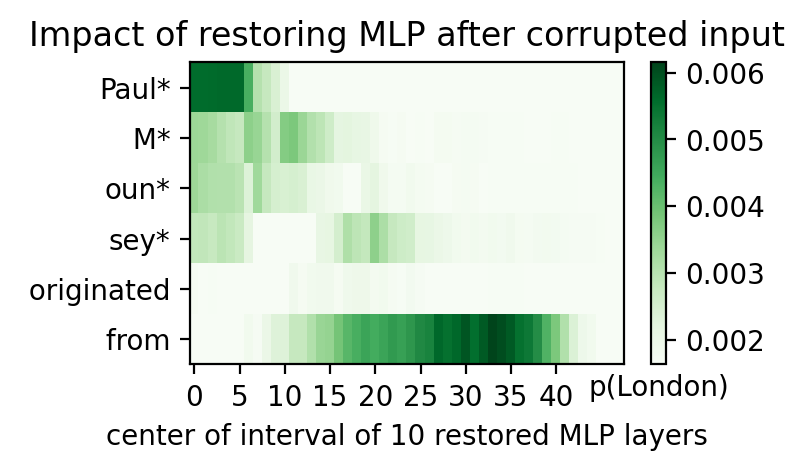

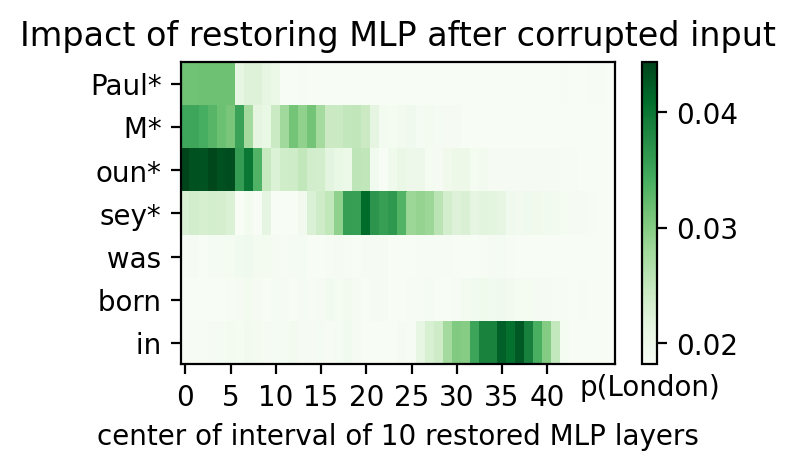

In [14]:
weird_data_ix = 0
sample_ix = weird_data.iloc[weird_data_ix]["sample_ix"]
token_ix = queries.loc[sample_ix]["top10_tokens"].index(weird_data.iloc[weird_data_ix]["lama_answer"])
results = dict(np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True))
results["scores"] = results["scores"][:,:,token_ix]
results["low_score"] = results["low_score"][token_ix]
results["high_score"] = results["high_score"][token_ix]
results["answer"] = queries.loc[sample_ix]["top10_tokens"][token_ix]
plot_trace_heatmap(results)

sample_ix = weird_data.iloc[weird_data_ix]["lama_ix"]
results = dict(np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True))
results["scores"] = results["scores"][:,:,token_ix]
results["low_score"] = results["low_score"][token_ix]
results["high_score"] = results["high_score"][token_ix]
results["answer"] = queries.loc[sample_ix]["top10_tokens"][token_ix]
plot_trace_heatmap(results)

#### Analysis of case 2: KL div low when inconsistent

In [85]:
weird_data = cand_data[~(cand_data.is_consistent) & (cand_data.kl_div<0.05)]
weird_data

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,lama_te,sample_te,is_consistent,kl_div
0,1,0,Allan Peiper,{} was born in,{} is originally from,London,Canada,0.017587,0.003975,False,0.009200
1,2,0,Allan Peiper,{} was born in,{} was originally from,London,Canada,0.017587,0.003594,False,0.009349
2,3,0,Allan Peiper,{} was born in,{} is native to,London,Canada,0.017587,0.002433,False,0.048972
3,4,0,Allan Peiper,{} was born in,{} was native to,London,Canada,0.017587,0.002815,False,0.039520
13,16,14,Moe Koffman,{} was born in,{} was originally from,Brooklyn,Chicago,0.028486,0.018155,False,0.009812
...,...,...,...,...,...,...,...,...,...,...,...
1195,1395,1393,Ranavalona I,{} was born in,{} was originally from,Italy,Spain,0.007253,0.012018,False,0.006412
1196,1396,1393,Ranavalona I,{} was born in,{} is native to,Italy,Spain,0.007253,0.002456,False,0.009704
1197,1397,1393,Ranavalona I,{} was born in,{} was native to,Italy,Spain,0.007253,0.006493,False,0.004055
1198,1398,1393,Ranavalona I,{} was born in,{} originated from,Italy,Spain,0.007253,0.007056,False,0.022180


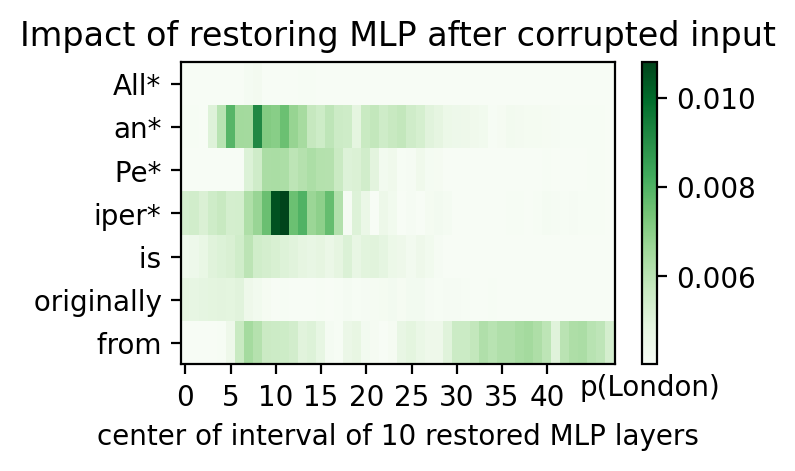

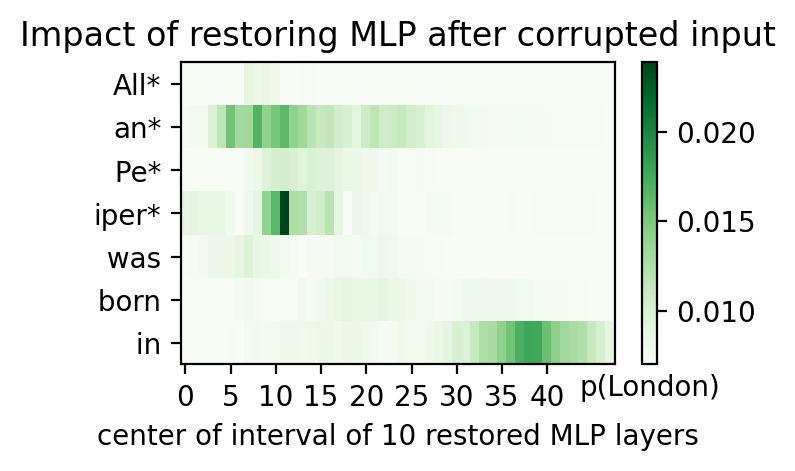

In [86]:
weird_data_ix = 0
sample_ix = weird_data.iloc[weird_data_ix]["sample_ix"]
token_ix = queries.loc[sample_ix]["top10_tokens"].index(weird_data.iloc[weird_data_ix]["lama_answer"])
results = dict(np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True))
results["scores"] = results["scores"][:,:,token_ix]
results["low_score"] = results["low_score"][token_ix]
results["high_score"] = results["high_score"][token_ix]
results["answer"] = queries.loc[sample_ix]["top10_tokens"][token_ix]
plot_trace_heatmap(results)

sample_ix = weird_data.iloc[weird_data_ix]["lama_ix"]
results = dict(np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True))
results["scores"] = results["scores"][:,:,token_ix]
results["low_score"] = results["low_score"][token_ix]
results["high_score"] = results["high_score"][token_ix]
results["answer"] = queries.loc[sample_ix]["top10_tokens"][token_ix]
plot_trace_heatmap(results)